# Introduction

So far, we've jointly optimized purity and completeness using a recent SAGA II+ catalog (2021-02-11). However, we haven't optimized a CNN *as a function of target density*. Moreover, we haven't been able to optimize the models so that the resultant redshift distributions look like [Yao's plots](https://hackmd.io/@yymao/SJ8v0KhZO).

Here we will do a few new things:
- use the 2021-02-19 data set (updated with new redshifts and a few

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

seed = 256

%matplotlib inline

In [2]:
import sys
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from utils import *

metrics = [accuracy, F1Score(), Recall(), Precision()]

sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *

In [3]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

## Util functions from last time

In [4]:

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(224)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)
seed = 256


def oversample(df: pd.DataFrame, num_oversample=None, label_column='lower_z'):
    """Oversample a `pd.DataFrame` such that `label_column` classes
    are balanced. Note that the result is not shuffled.
    """
    lst = [df]
    N_majority = (~df[label_column]).sum()
    N_minority = ( df[label_column]).sum()
    
    try:
        # -1 -> rebalance casses, other negative numbers will raise a ValueError
        if num_oversample == -1: num_oversample = N_majority - N_minority
        lst.append(df[df[label_column]].sample(num_oversample, replace=True))
    except ValueError:
        print('Make sure that `num_oversample` is larger than the number of objects in the label class')

    return pd.concat(lst)

def get_saga_dls(
    saga, 
    label_column='lower_z',
    split_column=None,
    oversample=None, 
    undersample=None, 
    valid_pct=0.25, 
    bs=64, 
    PATH=PATH,
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=256,
):
    """Returns Dataloaders `dls` based on an input catalog `saga`. 
    If `undersample` is an integer, then it will sample fewer from the 
    nonsatellites class. If `oversample` is an integer, then it will sample
    that many satellites. User can also provide fraction of sample 
    for validation by supplying `valid_pct`.
    """
    
    
    is_low_z = (saga.SPEC_FLAG == 1) & (saga[label_column] == 1) # 1 == True

    if undersample is None:
        df = saga.copy()
    elif isinstance(undersample, int):
        df = pd.concat(
            (saga[~is_low_z].sample(undersample), saga[is_low_z]),
        )
    else:
        raise TypeError('Please enter an integer for `undersample`')
    
    if split_column is None:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    elif split_column in df.columns:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=ColSplitter(split_column),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    else:
        raise TypeError('Please enter a valid column for splitting train/valid subsets')
    
    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    if oversample is not None:
        return resample_dls(
            dls, label_column=label_column, split_column=split_column, num_oversample=oversample,
            bs=bs, PATH=PATH, item_tfms=item_tfms, batch_tfms=batch_tfms, seed=seed
        )
    else:
        return dls
    

def resample_dls(
    dls, 
    label_column='HAS_SAT_Z', 
    num_oversample=None,
    split_column=None,
    bs=64, PATH=PATH, 
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=seed,
):
    """Given Dataloaders `dls` -- you may need to run `get_saga_dls()` first --
    oversample the satellites (generally outnumbered 100:1) in order to
    balance the classes. The classes are split by a binary `label_column`,
    which defaults to 'HAS_SAT_Z'. 
    
    Note that this method is probably not memory efficient.
    """
    train = dls.train.items.copy()
    valid = dls.valid.items.copy()

    train_oversampled = oversample(train, num_oversample=num_oversample, label_column=label_column)

    if split_column is None:
        split_column = 'is_valid'
        train_oversampled[split_column] = False
        valid[split_column] = True
        
    df_oversampled = pd.concat((train_oversampled, valid)).sample(frac=1)
    
    # create resampled datablock
    dblock_oversampled = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader(label_column),
        splitter=ColSplitter(split_column),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    return ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs)

In [5]:
def get_top_N_metrics(subset, N):
    
    metrics = {}
    
    # z<0.02
    TP = ((subset.index < N) & (subset.SPEC_Z < 0.02)).sum()
    TN = ((subset.index > N) & (subset.SPEC_Z > 0.02)).sum()
    FP = ((subset.index < N) & (subset.SPEC_Z > 0.02)).sum()
    FN = ((subset.index > N) & (subset.SPEC_Z < 0.02)).sum()
    
    metrics['completeness_02'] = TP / (TP + FN)

    # z<0.03
    TP = ((subset.index < N) & (subset.SPEC_Z < 0.03)).sum()
    TN = ((subset.index > N) & (subset.SPEC_Z > 0.03)).sum()
    FP = ((subset.index < N) & (subset.SPEC_Z > 0.03)).sum()
    FN = ((subset.index > N) & (subset.SPEC_Z < 0.03)).sum()
#     metrics['completeness_03'] = TP / (TP + FN)
    metrics['purity_03'] = TP / (TP + FP)
    
    metrics['geometric_mean'] = np.sqrt(metrics['completeness_02'] * metrics['purity_03'])
    metrics['harmonic_mean'] = 2 / (1/metrics['completeness_02'] + 1/metrics['purity_03'])
    
    return metrics

# A simple model to minimize median redshift

In [47]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [48]:
sz = 80
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 1024  

In [49]:
# regress on redshift
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('SPEC_Z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [50]:
dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

(no oversampling yet)

## Optimize with MAE (L1) loss 

In [51]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

In [52]:
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=L1LossFlat(),
)

# learn.lr_find()

In [53]:
learn.fit_one_cycle(10, 0.003)

epoch,train_loss,valid_loss,time
0,0.116335,0.117386,01:16
1,0.090350,0.092230,01:16
2,0.083886,0.079865,01:16
3,0.076429,0.085040,01:21
4,0.070995,0.076891,01:26
5,0.068586,0.066685,01:17
6,0.065855,0.068948,01:16
7,0.063937,0.063846,01:16
8,0.065029,0.063306,01:17
9,0.062644,0.063408,01:17


In [64]:
# learn.save('hybridcnn-simple_L1')
learn.load('hybridcnn-simple_L1')

## Check metrics

In [65]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_z'] = preds.flatten()

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Predicting $z$ (L1 Loss)')

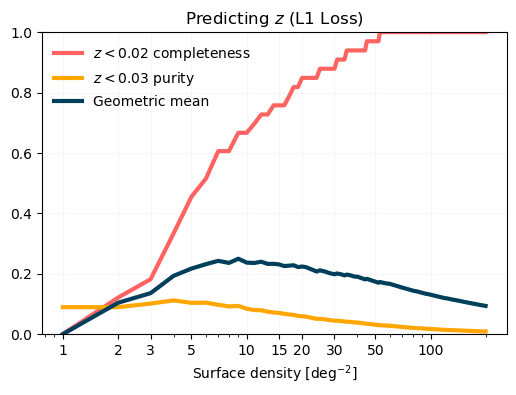

In [56]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_z', ascending=True).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L1 Loss)')

Text(0.5, 1.0, 'Predicting $z$ (L1 Loss)')

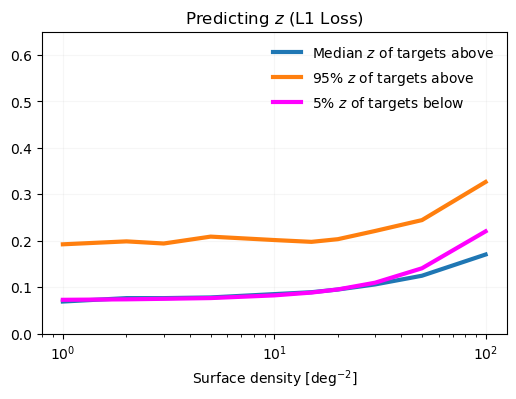

In [66]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_z', ascending=True)[:N]
    complement = res[mag_range].sort_values('pred_z', ascending=True)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')


plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L1 Loss)')

## MSE

In [58]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=MSELossFlat(),
)

learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.026480,0.032365,01:16
1,0.022321,0.024844,01:16
2,0.019749,0.020426,01:16
3,0.015207,0.019811,01:16
4,0.019832,0.018982,01:17
5,0.014266,0.018239,01:16
6,0.013907,0.017858,01:16
7,0.014429,0.017445,01:17
8,0.020870,0.017097,01:16
9,0.017475,0.017024,01:16


In [59]:
# learn.save('hybridcnn-simple_L2')

In [60]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_z'] = preds.flatten()

Text(0.5, 1.0, 'Predicting $z$ (L2 Loss)')

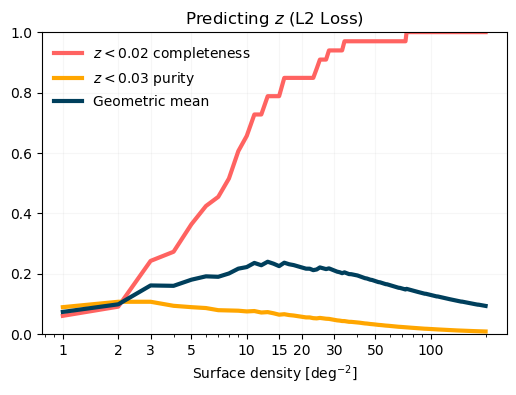

In [61]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_z', ascending=True).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L2 Loss)')

Text(0.5, 1.0, 'Predicting $z$ (L2 Loss)')

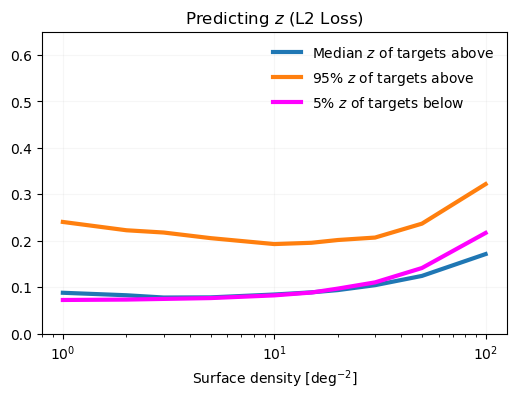

In [63]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_z', ascending=True)[:N]
    complement = res[mag_range].sort_values('pred_z', ascending=True)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Predicting $z$ (L2 Loss)')

# Optimize classification with focal loss

In [30]:
# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [68]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [69]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=FocalLossFlat(),
)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.9120108485221863)

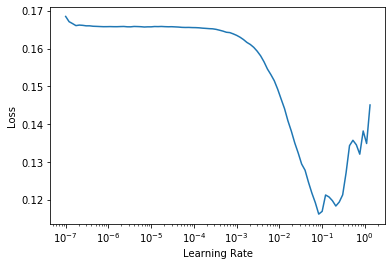

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.021430,0.023157,01:16
1,0.018919,0.019020,01:17
2,0.016201,0.015834,01:17
3,0.016490,0.013796,01:16
4,0.014749,0.013076,01:17
5,0.012628,0.013050,01:17
6,0.013335,0.012203,01:17
7,0.011875,0.011921,01:17
8,0.011216,0.011637,01:17
9,0.012220,0.011701,01:17


In [70]:
# learn.save('hybridcnn-simple_focal')
learn.load('hybridcnn-simple_focal');

In [71]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.03$ (Focal Loss)')

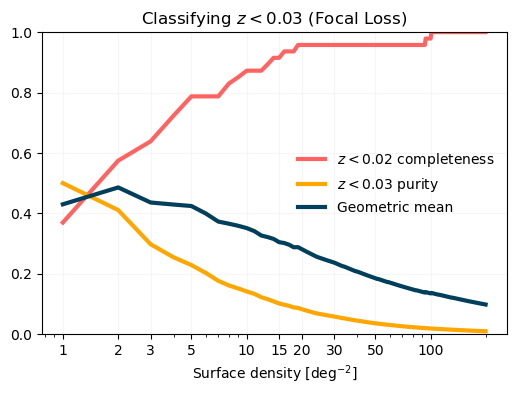

In [43]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(all_metrics_df.index, all_metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(all_metrics_df.index, all_metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(all_metrics_df.index, all_metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (Focal Loss)')

Text(0.5, 1.0, 'Classifying $z < 0.03$ (Focal Loss)')

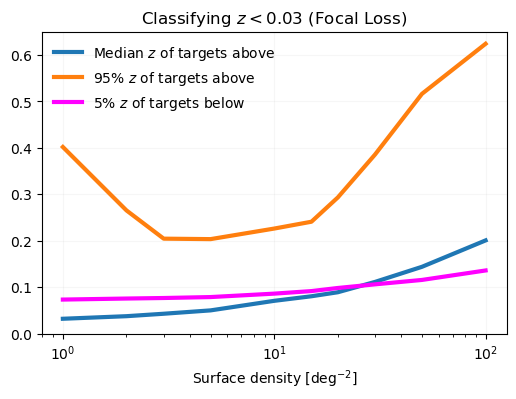

In [72]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (Focal Loss)')

# Label-smoothing cross entropy

In [73]:
# classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [75]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.1),
)

learn.fit_one_cycle(10, 1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,time
0,0.242696,0.239366,01:18
1,0.238181,0.235271,01:18
2,0.233227,0.229768,01:18
3,0.229359,0.231671,01:18
4,0.230564,0.228621,01:18
5,0.227549,0.226093,01:19
6,0.228772,0.225872,01:18
7,0.225038,0.224146,01:18
8,0.222954,0.223525,01:18
9,0.226166,0.223507,01:19


In [76]:
# learn.save('hybridcnn-simple_ce-ls')
learn.load('hybridcnn-simple_ce-ls');

In [77]:
preds, _ = learn.get_preds()

res = dls.valid.items.copy()
res['pred_low_z'] = preds.softmax(1)[:,1].numpy()

Text(0.5, 1.0, 'Classifying $z < 0.03$ (LS Cross Entropy)')

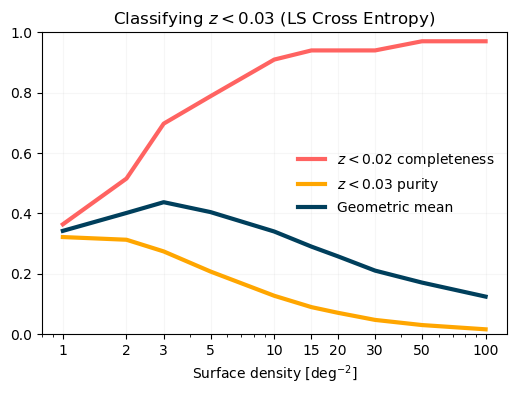

In [82]:
metrics_dict = {}

target_density_values = [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]
area = 0.2 * len(res.HOSTID.unique()) * np.pi * 1**2 # 0.2 is validation percent

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    mag_range = (19 < res.r_mag) & (res.r_mag < 21)
    subset = res[mag_range].sort_values('pred_low_z', ascending=False).reset_index()
    metrics = get_top_N_metrics(subset, N)
    metrics_dict[num_density] = metrics
    
all_metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').rename_axis('N_per_sq_deg')
metrics_df = all_metrics_df.loc[target_density_values]

# plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(metrics_df.index, metrics_df.completeness_02, c='#ff6361', lw=3, label='$z<0.02$ completeness')
plt.plot(metrics_df.index, metrics_df.purity_03, c='#ffa600', lw=3, label='$z<0.03$ purity')
plt.plot(metrics_df.index, metrics_df.geometric_mean, c='#003f5c', lw=3, ls='-', label='Geometric mean')

plt.ylim(0, 1)
plt.xscale('log')
plt.xticks(target_density_values, labels=target_density_values)

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (LS Cross Entropy)')

Text(0.5, 1.0, 'Classifying $z < 0.03$ (LS Cross Entropy)')

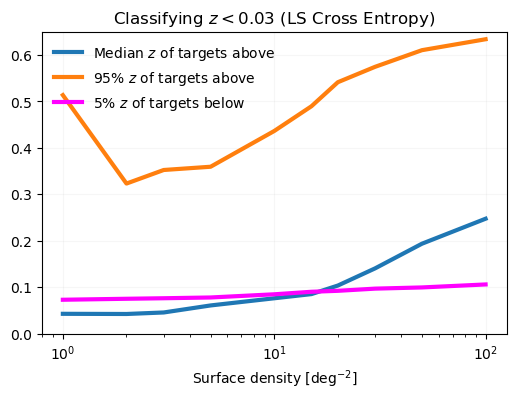

In [81]:
zdist_dict = {}

for num_density in np.arange(1, 200, 1):
    N = np.round(num_density * area).astype(int)
    
    subset = res[mag_range].sort_values('pred_low_z', ascending=False)[:N]
    complement = res[mag_range].sort_values('pred_low_z', ascending=False)[N:]
    
    zdist = {}
    
    zdist['p50_z_above'] = np.median(subset.SPEC_Z)
    zdist['p90_z_above'] = np.quantile(subset.SPEC_Z, 0.90)
    zdist['p95_z_above'] = np.quantile(subset.SPEC_Z, 0.95)
    zdist['p99_z_above'] = np.quantile(subset.SPEC_Z, 0.99)
    
    zdist['p10_z_below'] = np.quantile(complement.SPEC_Z, 0.10)
    zdist['p05_z_below'] = np.quantile(complement.SPEC_Z, 0.05)
    zdist['p01_z_below'] = np.quantile(complement.SPEC_Z, 0.01)

    
    zdist_dict[num_density] = zdist
    
all_zdist_df = pd.DataFrame.from_dict(zdist_dict, orient='index').rename_axis('N_per_sq_deg')
zdist_df = all_zdist_df.loc[target_density_values]

# Plot
plt.figure(figsize=(6,4), dpi=100)

plt.plot(zdist_df.index, zdist_df.p50_z_above, c='C0', lw=3, label='Median $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p95_z_above, c='C1', lw=3, label='95% $z$ of targets above')
plt.plot(zdist_df.index, zdist_df.p05_z_below, c='magenta',  lw=3, label='5% $z$ of targets below')
plt.grid(alpha=0.2)
plt.ylim(0, 0.65)
plt.xscale('log')

plt.xlabel('Surface density [deg$^{-2}$]')
plt.grid(alpha=0.1)
plt.legend(framealpha=0)

plt.title('Classifying $z < 0.03$ (LS Cross Entropy)')

# Optimize classification prediction *and* penalize higher redshift

## Includes Cross Entropy

In [16]:
# regress on redshift
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
    get_y=ColReader('SPEC_Z'),
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [17]:
dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

In [19]:
model = nn.Sequential(
    FastDeconv(3, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 32, 3, stride=2), MishCuda(),
    FastDeconv(32, 64, 3), MishCuda(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

## Includes Focal Loss